In [3]:
import bs4 as bs
import urllib.request
import re
from sklearn.manifold import TSNE
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import pandas as pd
import make_datasets as src
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import numpy as np

In [4]:
def tsne_plot(model, figsize = (16, 16)):
    labels = []
    tokens = []
    
    for word in model.wv.index_to_key:
        tokens.append(model.wv[word])
        labels.append(word)
    tokens = np.array(tokens)
    print(len(tokens))
    
    
    tsne_model = TSNE(perplexity=9, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    x = []
    y = []
    
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=figsize) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
        plt.xlabel("dimension 1")
        plt.ylabel("dimension 2")
    plt.show()

In [ ]:
def classify_semantic(activity:str, topic_vectors, model, threshold = 0.4):
    act_vec = model.encode(activity)
    matched = []
    for topic, vec in topic_vectors.items():
        sim = util.cos_sim(act_vec, vec).item()
        if sim > threshold:
            matched.append((topic, round(sim, 2)))
    return sorted(matched, key=lambda x: -x[1])

def classify_activities_df(df, text_column, topic_vectors,model, threshold=0.4):
    results = []
    for i, row in df.iterrows():
        topics_with_sim = classify_semantic(row[text_column], topic_vectors, model, threshold)
        matched_topics = [t[0] for t in topics_with_sim]
        sims = [t[1] for t in topics_with_sim]
        results.append({
            "activity_id": row["activity_id"],
            "name": row["name"],
            "code": row["code"],
            "text": row[text_column],
            "temas": matched_topics if matched_topics else "not found",
            "similitud": sims if sims else 0
        })
    return pd.DataFrame(results)


def explode_topics_df(df_with_topics):
    rows = []

    for _, row in df_with_topics.iterrows():
        temas = row["temas"]
        sims = row["similitud"]

        if temas == "not found":
            rows.append({
                "activity_id": row["activity_id"],
                "name": row["name"],
                "code": row["code"],
                "text": row["text"],
                "tema": "not found",
                "similitud": 0
            })
        else:
            for tema, sim in zip(temas, sims):
                rows.append({
                    "activity_id": row["activity_id"],
                    "name": row["name"],
                    "code": row["code"],
                    "text": row["text"],
                    "tema": tema,
                    "similitud": sim
                })

    return pd.DataFrame(rows)

def classify(x):
    themes = ["money", "people", "sport", "vida diaria", "transport", "animals", "formas"]
    logic = ["logica", "Calculo", "Numbers"]

    if x in themes:
        return "themes"
    elif x in logic:
        return "logic"
    else:
        return x

In [24]:
topics = {
    'transport':  [
    "metro", "parada", "paradas", "estación", "tráfico", "vuelo", "aeropuerto", "velocidad",
    "tren", "tranvía", "autobús", "intercambiador","evitar multa",
    "carretera", "autopista", "avenida", "conducción",  "atasco",
    "señal de tráfico", "vehículo", "auto", "coche",
    "avión", "piloto", "despegue", "puerta de embarque", "billete de avión",
    "barco", "ferry", "puerto", "crucero", "lancha", "navegación",
    "ruta", "trayecto", "recorrido", "destino", "transporte urbano","frecuencia", "maletas", "estación", "vuelo", "aeropuerto"],
    
    "people": [
        "imagen", "foto", "personas", "caras", "nombre","vístete (mujer)",
        "rostro", "gente", "individuo", "figura", "silueta",
        "retrato", "selfie", "usuario", "identidad", "modelo",
        "niño", "niña", "hombre", "mujer", "persona",
        "grupo", "multitud", "asistencia", "presencia", "semblante",
        "expresión", "mirada", "perfil", "nombre completo", "apellido"
    ],
    
        'animals': ["animales", "perro", "gatos", "bichos", "aleteo", "mariposa",
        "mascotas", "gatito", "perrito", "animalito", "fauna",
        "criatura", "insecto", "pájaro",
        "pez", "caballo", "vaca", "oveja", "cerdo",
        "conejo", "hamster", "reptil", "anfibio", "zoológico","separa los bichos",
    ],
    'money': [
        "billetes", "monedas", "cantidad", "dinero",
        "efectivo", "pago", "precio", "cuenta", "tarjeta",
        "saldo", "cobro", "gasto", "ahorro", "ingreso",
        "transferencia", "cheque", "banco", "cartera", "fortuna",
        "riqueza", "valor", "presupuesto", "divisa", "capital",
        "interés", "deuda", "crédito", "retiro", "depósito"
    ],
    
    "sport": [
        "football", "balón", "pelota", "golpe", "basketball",
        "deporte", "entrenamiento", "partido", "jugador", "equipo",
        "gol", "pase", "tiro", "marcador", "victoria",
        "derrota", "carrera", "salto", "natación", "ciclismo",
        "boxeo", "tenis", "voley", "surf", "esquí",
        "pesas", "gimnasio", "fitness",  "fuerza"
    ],
    "sequence": ["secuencia", "order", ],
    "formas": ["formas", "dibujo", "figuras", "color"],

    "vida diaria": [
        "reciclar la basura", "hogar", "recoger la habitación", "ir de compras", "vida diaria", "conducir",
        "comida", "platos", "cocina", "agua", "vístete (mujer)", 
        "lavar la ropa", "hacer la cama", "barrer", "fregar", "poner la mesa",
        "quitar la mesa", "sacar la basura", "ducharse", "lavarse los dientes",
        "despertarse", "desayunar", "almorzar", "cenar", "ir al trabajo",
        "hacer la compra", "pagar facturas", "cuidar a los niños", "descansar", "organizar",
        "limpiar", "preparar la comida", "planchar", "tiempo libre", "tareas domésticas"
    ],
    
    "logica": [
        "puzzle", "rompecabezas", "lógica", "razonamiento", "deducción", "laberinto"
        "estrategia", "acertijo", "enigma", "problema", "solución",
        "patrón", "símbolos", "reglas", "análisis", "inferencias",
        "pensamiento crítico", "argumento", "conclusión", "secuencia lógica", "decisión"
    ],

    "Lingüístico": [ "lenguaje", "palabras", "letras", "sílabas", "phrases", "lingüístico",
        "texto", "frases", "lectura", "escritura", "significado",
        "vocabulario", "gramática", "comunicación", "narración", "cuentos",
        "diálogo", "pronunciación", "discurso", "oración", "poesía",
        "idioma", "conjugación", "verbo", "adjetivo", "sustantivo", "escrita", "preguntas", "responder"
    ], 
    
    'Calculo': [ "calcular", "cálculo", "sumar","cantidad", "matemáticas",
        "restar", "multiplicar", "dividir", "porcentaje", "ecuación", "medida", "cifra", "estimación", "valor",
        "operación", "fracción", "decimal", "estadística"
    ],
    'Auditivos': [ "señal", "señales", "sonidos", "música", "audio",
        "ruido", "voz", "melodía", "ritmo", "tono",
        "volumen", "eco", "vibración", "frecuencia", "acústica",
        "altavoz", "auriculares", "micrófono", "grabación", "podcast",
        "susurro", "estruendo", "aplausos", "canción", "banda sonora",
        "radio", "diálogo", "armonía", "timbre", "reverberación"
    ], #
       "Numbers": ["números",],
    }

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
topic_vectors = {topic: model.encode(" ".join(keywords)) for topic, keywords in topics.items()}

In [28]:
topic_vectors["Auditivos"]

array([ 1.35932937e-01, -9.11982581e-02,  1.56577319e-01, -1.14474863e-01,
       -6.99657649e-02,  6.00422993e-02,  1.75260827e-01, -1.36514083e-01,
        1.71792179e-01,  1.45495385e-01,  8.70819762e-02, -1.85810756e-02,
        5.41880950e-02, -2.68794775e-01,  2.04876930e-01,  2.72815466e-01,
        3.29247355e-01,  2.66921043e-01, -9.66873839e-02,  3.90763395e-02,
        4.68044430e-02,  2.69179523e-01, -1.61309198e-01,  2.15441547e-03,
       -3.05105865e-01,  1.39789293e-02, -2.26747945e-01, -2.45203990e-02,
        3.82319801e-02,  6.13140762e-02, -7.84768898e-04,  2.04701141e-01,
        2.25517273e-01, -1.88070238e-01, -1.75927028e-01,  1.01339817e-01,
       -7.22081587e-02, -5.39404601e-02, -5.48745275e-01,  1.96670592e-01,
       -3.01548988e-02, -1.52714908e-01, -8.29946920e-02, -3.00134033e-01,
       -3.29955608e-01, -3.49934876e-01, -1.35816246e-01, -6.89565018e-02,
       -9.50958133e-02,  1.82517394e-02, -1.16844267e-01,  2.55580489e-02,
       -3.33298440e-03,  

In [8]:
query = """
	select c.activity_id, a.code, act.name, act.description, coalesce(cg.instructions, cc.instructions, cgen.instructions) as instructions, 
	act.keywords
	from nup_configuration c
	join nup_activity_translation act on c.activity_id = act.translatable_id and c.locale = act.locale
	left join nup_activity a on a.id = c.activity_id 
	left join nup_configuration_option co on co.id = c.id
	left join nup_configuration_game cg on cg.configuration_id = c.id
	left join nup_configuration_card cc on cc.configuration_id = c.id
	left join nup_configuration_generator cgen on cgen.configuration_id = c.id
	left join nup_type t on t.id = c.type_id
	where act.locale = 'es_ES' 
	and c.enabled = 1 and c.kind = 1 and (c.format_id = 1 or c.format_id is null) 
	and c.activity_id not in (select id from excluded_activities)
	and a.enabled = 1
"""
conn = src.connect_maria_db("empty_neuronup")
data = pd.read_sql(query, conn).drop_duplicates()
data_clf_neuros = pd.read_csv("data_clf_neuros.csv")

In [10]:
stop_words = [
    'esta', 'actividad', 'consiste', 'en', 'la', 'el', 'los', 'las', 'con', 'sobre',
    'de', 'una', 'para', 'que', 'y', 'se', 'un', 'lo', 'al', 'del','hasta', 'dos', 'une', 'elementos', 'cartas',
    'más', 'posible', 'manera', 'encontrar', 'su', 'vez', 'cada', 'dónde', 'sonidos', 'están', 'donde', 'estaban', 'ni', 'todos', 'fíjate' 
]

df = data[["activity_id", "code", "name", "description", "instructions", "keywords"]].drop_duplicates()
selected_cols = ["Código",  "Recomendaciones", "Contenido", "Temáticas", "Educativas"] # "Adaptabilidad e interacción",
merged_df = df.merge(data_clf_neuros[selected_cols], how = "left", left_on = "code", right_on = "Código").fillna("/")

final_cols_to_select =[x for x in ["name", "description", "instructions"] + selected_cols if x != "Código"]
merged_df["text"] = ""
for col in final_cols_to_select:
    merged_df["text"] += merged_df[col].astype(str) + ' '
    
merged_df["text"] = merged_df["text"].apply(lambda x:  re.sub(r'[\s/.,*%]+', ' ', x))
merged_df["text"] = merged_df["text"].apply(lambda x: x.lower())

In [14]:
result_df = classify_activities_df(merged_df, "text", topic_vectors, model, threshold=0.2)
clf_df = explode_topics_df(result_df)

In [33]:
clf_df

,activity_id,name,code,text,tema,similitud
0,351,Consecuencias,ER1,consecuencias determinar las consecuencias pos...,Lingüístico,0.44
1,351,Consecuencias,ER1,consecuencias determinar las consecuencias pos...,logica,0.32
2,351,Consecuencias,ER1,consecuencias determinar las consecuencias pos...,people,0.26
3,351,Consecuencias,ER1,consecuencias determinar las consecuencias pos...,Auditivos,0.26
4,351,Consecuencias,ER1,consecuencias determinar las consecuencias pos...,Calculo,0.21
...,...,...,...,...,...,...
1624,1869,Programa el robot,SG-ASU32-K,programa el robot copiar en espejo la posición...,people,0.29
1625,1872,Ordena la estantería,SG-ASU32-A,ordena la estantería copiar en espejo la posic...,formas,0.45
1626,1872,Ordena la estantería,SG-ASU32-A,ordena la estantería copiar en espejo la posic...,people,0.32
1627,1872,Ordena la estantería,SG-ASU32-A,ordena la estantería copiar en espejo la posic...,logica,0.23


In [8]:
import plotly.express as px
clf_df["main_groups"] = clf_df["tema"].apply(classify)
px.bar(
    data_frame = clf_df.groupby(["main_groups", "tema"])["activity_id"].nunique().reset_index(name = "num_act"),
    x = "main_groups",
    y = "num_act",
    color = "tema",
    barmode = "group",
)

23


c:\Users\elina.filatova_neuro\Desktop\smart_search\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.

c:\Users\elina.filatova_neuro\Desktop\smart_search\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning:

Could not find the number of physical cores for the following reason:
[WinError 2] El sistema no puede encontrar el archivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.

  File "c:\Users\elina.filatova_neuro\Desktop\smart_search\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\elina.filatova_neuro\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as 

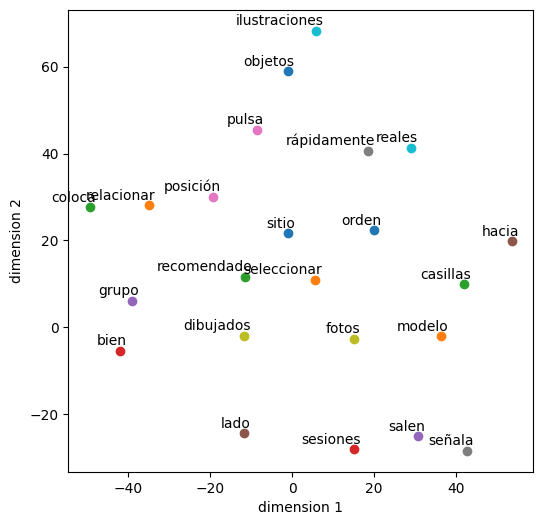

In [9]:
import numpy as np
import matplotlib.pyplot as plt

cleaned_text = ''
# cleaned_text = []
text = [row for row in clf_df[clf_df["tema"] == "not found"]["text"]]
for row in text:
    new_row = ''
    for word in row.split(' '):
        if word.lower() not in stop_words and word.lower() not in stopwords.words('spanish'):
            
            new_row += word.lower() + ' ' 
    cleaned_text += re.sub(r'[\s+,*/?!)()]', ' ', new_row) + ' '
    # cleaned_text.append(re.sub(r'\s+', ' ', new_row))
all_sentences = nltk.sent_tokenize(cleaned_text)
all_words = [nltk.word_tokenize(sent) for sent in all_sentences]
word2vec = Word2Vec(all_words, min_count=5, workers=4)
tsne_plot(word2vec, (6,6))

In [10]:
clf_df[clf_df["tema"] == "not found"]["text"][543]

'copia de planos esta actividad consiste en copiar la posición de las casillas de la figura modelo coloca todas las casillas igual que en el modelo mapas planos actividad con elementos dibujados (ilustraciones) actividad de conducir '

In [11]:
clf_df[clf_df["tema"] == "not found"]

,activity_id,name,code,text,tema,similitud,main_groups
45,389,"Objetos, establecimientos y profesionales",OP2,objetos establecimientos y profesionales relac...,not found,0.0,not found
79,492,Objetos tapados,GV12,objetos tapados reconocer objetos tapados parc...,not found,0.0,not found
145,743,Última ventana iluminada,J_ultVent,última ventana iluminada esta actividad consis...,not found,0.0,not found
150,748,Primer aleteo,J_aleteo,primer aleteo esta actividad consiste en memor...,not found,0.0,not found
151,749,Localización espacial,J_ubiE,localización espacial esta actividad consiste ...,not found,0.0,not found
156,752,Separa los bichos,J_bichos,separa los bichos esta actividad consiste en r...,not found,0.0,not found
179,767,Copia de planos,J_plazas,copia de planos esta actividad consiste en cop...,not found,0.0,not found
181,769,Pirámide de cartas,J_piramide,pirámide de cartas esta actividad consiste en ...,not found,0.0,not found
193,779,Pirámide de cartas de póquer,J_piramide_poker,pirámide de cartas de póquer esta actividad co...,not found,0.0,not found
217,802,Dibujos en movimiento,EWM64,dibujos en movimiento memorizar el lugar donde...,not found,0.0,not found


In [12]:
topics = {
    # tematics
    'transport':  [
        "equipaje",
        "metro", "parada", "paradas", "estación", "tráfico", "vuelo", "aeropuerto", "velocidad",
        "tren", "tranvía", "autobús", "intercambiador","evitar multa",
        "carretera", "autopista", "avenida", "conducción",  "atasco",
        "señal de tráfico", "vehículo", "auto", "coche",
        "avión", "piloto", "despegue", "puerta de embarque", "billete de avión",
        "barco", "ferry", "puerto", "crucero", "lancha", "navegación",
        "ruta", "trayecto", "recorrido", "destino", "transporte urbano","frecuencia", "maletas", "estación", "vuelo", "aeropuerto"
    ],
    
    "people": [
     "foto de persona", "personas", "caras", "nombre","vístete (mujer)",
        "rostro", "gente", "individuo",
        "niño", "niña", "hombre", "mujer", "persona",
    ],
    
    # 'food': ["comida", "platos", "cocina", "agua"],
    'animals': [
        "encuentra a toby","encuentra los peces",
        "animales", "perro", "gatos", "bichos", "aleteo", "mariposa",
        "mascotas", "gatito", "perrito", "animalito", "fauna",
        "criatura", "insecto", "pájaro",
        "pez", "caballo", "vaca", "oveja", "cerdo",
        "conejo", "hamster", "reptil", "anfibio", "zoológico","separa los bichos",
    ],
    'money': [
        "billetes", "monedas", "cantidad", "dinero",
        "efectivo", "pago", "precio", "cuenta", "tarjeta",
        "saldo", "cobro", "gasto", "ahorro", "ingreso",
        "transferencia", "cheque", "banco", "cartera", "fortuna",
        "riqueza", "valor", "presupuesto", "divisa", "capital",
        "interés", "deuda", "crédito", "retiro", "depósito"
    ],
    
    "sport": [
        "football", "balón", "pelota", "golpe", "basketball",
        "deporte", "entrenamiento", "partido", "jugador", "equipo",
        "gol", "pase", "tiro", "marcador", "victoria",
        "derrota", "carrera", "salto", "natación", "ciclismo",
        "boxeo", "tenis", "voley", "surf", "esquí",
        "pesas", "gimnasio", "fitness",  "fuerza"
    ],
    
    "sequence": ["secuencia", "order",],
    # "emotions": ["emotions", "sad", "angry", "social"],

    "vida diaria": [
        "reciclar la basura", "hogar", "recoger la habitación","evitar multa", "ir de compras", "vida diaria", "conducir",
        "comida", "platos", "cocina", "agua", "vístete (mujer)", 
        "lavar la ropa", "hacer la cama", "barrer", "fregar", "poner la mesa",
        "quitar la mesa", "sacar la basura", "ducharse", "lavarse los dientes",
        "despertarse", "desayunar", "almorzar", "cenar", "ir al trabajo",
        "hacer la compra", "pagar facturas", "cuidar a los niños", "descansar", "organizar",
        "limpiar", "preparar la comida", "planchar", "tiempo libre", "tareas domésticas"
    ],
    
    "logica": [
        "puzzle", "rompecabezas", "laberinto", "laberintos", "laberinto", "combinaciones"
    ],
    "ilustrations": ["dibujos", "illustraciones"],
    "formas" : ["formas", "figuras", "colores"],
    
    # "Computer" : ["teclado","Teclado físico", "with computer mouse"], # etc
    # "Tablet": ["Pulsar", "Recomendadas para tablet", "tablet", "pantalla táctil", "Arrastrar", "Pulsar"],
    # "groups": ["Recomendado para sesiones en grupo", "grupos", "grupo"],
    
    # actions
    "Lingüístico": [ "lenguaje", "palabras", "letras", "sílabas", "phrases", "lingüístico",
        "texto", "frases", "lectura", "escritura", "significado",
        "vocabulario", "gramática", "comunicación", "narración", "cuentos",
        "diálogo", "pronunciación", "discurso", "oración", "poesía",
        "idioma", "conjugación", "verbo", "adjetivo", "sustantivo", "escrita", "preguntas", "responder"
    ], # linguistic / read or all related to words letters frases etc
    
    "Numbers": ["números",],
    
    'Calculo': [ "calcular", "cálculo", "sumar","cantidad", "matemáticas",
        "restar", "multiplicar", "dividir", "porcentaje", "ecuación", "medida", "cifra", "estimación", "valor",
        "operación", "fracción", "decimal", "estadística"
    ],
    'Auditivos': [ "señal", "señales", "sonidos", "música", "audio",
        "ruido", "voz", "melodía", "ritmo", "tono",
        "volumen", "eco", "vibración", "acústica",
        "altavoz", "auriculares", "micrófono", "grabación", "podcast",
        "aplausos", "canción","radio", "diálogo", 
    ], #
    
    "reflection": ["casillas", "igual", "copiar", "posición", "espejo"],
    
    "clock" : ["hora", "reloj", "tiempo", "relojes", "horas", "interpretar la hora"],
    
    }

model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
topic_vectors = {topic: model.encode(" ".join(keywords)) for topic, keywords in topics.items()}

In [13]:
result_df = classify_activities_df(merged_df, "text", topic_vectors, model, threshold=0.25)
clf_df = explode_topics_df(result_df)

In [14]:
import plotly.express as px
clf_df["main_groups"] = clf_df["tema"].apply(classify)
px.bar(
    data_frame = clf_df.groupby(["main_groups", "tema"])["activity_id"].nunique().reset_index(name = "num_act"),
    x = "main_groups",
    y = "num_act",
    color = "tema",
    barmode = "group",
)

In [23]:
result_df[result_df["code"] == "LN1"]

,activity_id,name,code,text,temas,similitud
13,379,Nombrar objetos con pistas fonológicas,LN1,nombrar objetos con pistas fonológicas nombrar...,"[Lingüístico, people, formas, Auditivos, logic...","[0.52, 0.5, 0.4, 0.38, 0.3, 0.21]"


In [41]:
comments = {
    "LN1": "remove Audiotivos and pistas fonológicas from DB",
}

new_tags = {
    "vida diaria": ["OP2", "GV12", "EP5", "EP65", "EP61"],
    
    "people": ["EP5", "EP65"],
    "ilustrations": [
        "EP65", "SG-PVC30-K", "EWM64", "ASE65", "J_aleteo", "J_ubiE", "J_plazas",
        "J_puzzleRota", "J_copia", "J_coco", "J_dispara", "SG-EP33-K", "SG-VSR33-K", "SG-ASU31-A", "GME71","J_baul"
    ],
    "animals": ["J_aleteo", "J_bichos", "J_copia","J_baul"], 
    "formas": ["J_ubiE", "J_coco"],
    "sequence": ["J_ultVent", "J_entrevista_child", "GME71", "J_en_orden"],
    "logica": ["J_puzzleRota", "J_coco", "GEP68", "SG-PVC30-K"],
    "reflection": ["J_copia","J_robot_children", "J_copia_adult", "SG-VSR33-K", "SG-ASU31-A", "SG-ASU32-K"],
    "people": ["J_entrevista_child", ],
    "sport" : ["J_pararPunto", "J_pararPunto_child", "SG-VSR32-K"],
    
    # "OP2": "vida diaria",
    # "GV12": "vida diaria", 
    # "J_ultVent":[ "sequence"],
    # "J_aleteo": ["animals", "dibujos"],
    # "J_ubiE": ["figures", "dibujos"],
    # "J_bichos": ["animals",],
    # "J_plazas": "dibujos",
    # "J_piramide": "cartas - game",
    # "J_piramide_poker": "cartas - game",
    # "EWM64": "dibujos",
    # "ASE65": "dibujos",
    # "J_puzzleRota": ["logica", "dibujos"],
    # "J_copia": ["dibujos", "animals", "reflection"],
    # "J_robot_children" : "reflection",
    # "J_coco": ["figures", "logica", "dibujos"],
    # "J_dispara": "dibujos",
    # "J_copia_adult":"reflection",
    # "GEP68": "laberinto",
    # "J_entrevista_child": ["people", "sequence"],
    # "SG-EP33-K": "dibujos",
    # "SG-VSR33-K":["reflection", "dibujos"],
    # "SG-ASU31-A": ["reflection","dibujos"],
    # "SG-ASU32-K":"reflection",
    
    # clock
#    "J_pararPunto":"conducir",
#    "J_pararPunto_child": "conducir",
#    "SG-VSR32-K": "conducir",
#    "EP5": ["people", "vida diaria"],
#    "EP65": ["people", "dibujos", "vida diaria"],
#    "EP61": ["vida diaria"],
#    "GME71": ["sequecne", "dibujos",],
#    "J_en_orden": ["sequence", ],
#    "J_baul": ["animals", "dibujos"],
#    "SG-PVC30-K": ["dibujos"],
   
}

1. Auditivos - ✅
fix descripton of LN1 (pistas fonológicas)
2. clock  - ✅
- J_pararPunto, J_pararPunto_child, SG-VSR32-A, SG-VSR32-K (change cat, conducir, dibujos)

3. formas - ✅
<!-- -SG-EI30-K	-Explota los globos assign dibujos -->

4. calculo - ✅
- VSR3, VSR2, J_memoria, J_memoria_adult  - remove from calculo
- APS66 - assign dibujos and remove from calculo
- SG-VSR32-A - 	assign dibujos / sport and remove from calculo
- SG-VSR32-K -  assign dibujos / conducir / sport and remove from calculo
- J_contarAudios, SG-ASU40-A - remove from calculo

5. Numbers 
- APS7, GAPS67, J_contarAudios, SG-ASU40-A- remove from numbers
6. Logica - add more labirints
7. reflection - super ✅

8. sequence
- remove: APS3,EP5, DES, EWM10, J_palabras, GAPS3,J_DES, EP65, GER10, MS76, MS7, GEWM21, ASU1-K, SG-LEX30-A	

9. animals
remove: ASE62,  GASE77, SG-PVC30-K	

10. money - super ✅

11. people

remove: LD1, LV10, LD4, LV70

12. sport 
remove: J_ranas, SG-VSR35-K	

13. transport
not many.. check a few more tiems


In [36]:
to_drop = [
    172, 223, 377, 385, 38, 40, 154, 252, 306, 317, 378, 386,
    412, 20, 157, 251, 411,21, 54, 62, 91, 111, 134, 145, 161, 
    194, 211, 271, 283, 357, 406, 149, 267, 369,8, 209, 237, 277,
    143, 387
]

In [33]:
clf_df[
    (clf_df["code"].isin(["J_ranas", "SG-VSR35-K"]))
    & (clf_df["tema"] == "sport") 
].index

Index([143, 387], dtype='int64')

In [38]:
clf_f1=  clf_df.drop(to_drop)

In [39]:
clf_f1[clf_f1["code"] == "J_puzzleRota"]

,activity_id,name,code,text,tema,similitud,main_groups
170,814,Imágenes revueltas,J_puzzleRota,imágenes revueltas mover bloques de una manera...,not found,0.0,not found


In [42]:
clf_f1[clf_f1["code"].isin(new_tags["vida diaria"])]

,activity_id,name,code,text,tema,similitud,main_groups
29,389,"Objetos, establecimientos y profesionales",OP2,objetos establecimientos y profesionales relac...,not found,0.00,not found
53,485,Ordenar pasos de actividades (imágenes),EP5,ordenar pasos de actividades (imágenes) poner ...,Lingüístico,0.27,Lingüístico
56,492,Objetos tapados,GV12,objetos tapados reconocer objetos tapados parc...,not found,0.00,not found
160,806,Pasito a pasito (dibujos),EP65,pasito a pasito (dibujos) poner en orden los d...,Lingüístico,0.26,Lingüístico
162,807,Pasito a pasito (texto),EP61,pasito a pasito (texto) poner en orden los dif...,sequence,0.27,sequence


In [43]:
new_tags["vida diaria"]

['OP2', 'GV12', 'EP5', 'EP65', 'EP61']

In [45]:
test_df = clf_f1.copy()

In [46]:
for key, codes in new_tags.items():
    print(codes)

['OP2', 'GV12', 'EP5', 'EP65', 'EP61']
['J_entrevista_child']
['EP65', 'SG-PVC30-K', 'EWM64', 'ASE65', 'J_aleteo', 'J_ubiE', 'J_plazas', 'J_puzzleRota', 'J_copia', 'J_coco', 'J_dispara', 'SG-EP33-K', 'SG-VSR33-K', 'SG-ASU31-A', 'GME71', 'J_baul']
['J_aleteo', 'J_bichos', 'J_copia', 'J_baul']
['J_ubiE', 'J_coco']
['J_ultVent', 'J_entrevista_child', 'GME71', 'J_en_orden']
['J_puzzleRota', 'J_coco', 'GEP68', 'SG-PVC30-K']
['J_copia', 'J_robot_children', 'J_copia_adult', 'SG-VSR33-K', 'SG-ASU31-A', 'SG-ASU32-K']
['J_pararPunto', 'J_pararPunto_child', 'SG-VSR32-K']


In [47]:
rows_to_concat = []

for key, codes in new_tags.items():
    df = clf_f1[clf_f1["code"].isin(codes)]

    for i, row in df.iterrows():
        if row["tema"] == "not found":
            clf_f1.loc[row.name, "tema"] = key
            
        else:
            copied_row = row.copy()
            copied_row["tema"] = key
            rows_to_concat.append(pd.DataFrame([copied_row]))
rows_df = pd.concat(rows_to_concat)
clf_f2 = pd.concat([clf_f1, rows_df])

clf_f2["main_groups"] = clf_f2["tema"].apply(classify)

In [2]:
import plotly.express as px
px.bar(
    data_frame = clf_f2.groupby(["main_groups", "tema"])["activity_id"].nunique().reset_index(name = "num_act"),
    x = "main_groups",
    y = "num_act",
    color = "tema",
    barmode = "group",
)

NameError: name 'clf_f2' is not defined

In [49]:
clf_f2[clf_f2["tema"] == "not found"]

,activity_id,name,code,text,tema,similitud,main_groups
1,352,Búsqueda de estímulos consecutivos,ASE3,búsqueda de estímulos consecutivos buscar entr...,not found,0.0,not found
9,356,Objetos en el hogar,OP3,objetos en el hogar ubicar en qué lugares de l...,not found,0.0,not found
10,356,Objetos en el hogar,OP3,objetos en el hogar ubicar en qué lugares de l...,not found,0.0,not found
15,362,Señalar la imagen diferente,APS6,señalar la imagen diferente señalar la imagen ...,not found,0.0,not found
41,476,Imágenes incompletas,GV4,imágenes incompletas seleccionar la opción que...,not found,0.0,not found
...,...,...,...,...,...,...,...
422,1830,Encuentra el monumento,SG-APS31-A,encuentra el monumento seguir las indicaciones...,not found,0.0,not found
424,1839,Teje la bufanda,SG-APS35-A,teje la bufanda recoger todos los ovillos que ...,not found,0.0,not found
435,1860,El mejor organizador,SG-EFX32-K,el mejor organizador organizar diversos elemen...,not found,0.0,not found
436,1863,Emparejamientos veloces,SG-APS34-A,emparejamientos veloces asociar los elementos ...,not found,0.0,not found


In [50]:
result_df = classify_activities_df(clf_f2[clf_f2["tema"] == "not found"], "text", topic_vectors, model, threshold=0.15)
clf_f3 = explode_topics_df(result_df)

In [51]:
clf_f3["main_groups"] = clf_f3["tema"].apply(classify)

In [52]:
import plotly.express as px
px.bar(
    data_frame = clf_f3.groupby(["main_groups", "tema"])["activity_id"].nunique().reset_index(name = "num_act"),
    x = "main_groups",
    y = "num_act",
    color = "tema",
    barmode = "group",
)

In [53]:
new_tags = {
    "vida diaria": ["ETE62","OP3" ],    
    # "people": [""],
    "ilustrations": ["ASE7-K", "AA65", "ME73", "J_loteria_child","J_pairs", "ASE7-K"],
    "clock" : ["ETE62"," ETE62", "ETE2", ],
    # "animals": [""], 
    "Calculo": ["ASE8", "ASE7", "ASE7-K"],
    "formas": ["APS6", "VSV3","APS8", "AA3", "J_matrix_colores", "J_croma", "J_entre", "SG-VSV30-A", "VSV3"],
    # "sequence": [""],
    "logica": ["ME73", "SG-EFX32-K", "AA63", "SG-EFX32-K"],
    "reflection": ["SG-VSR33-A"],
    "people": ["J_entrevista", ],
    # "sport" : [""],
    "Lingüístico": ["ASE3","GMS14", "GASE76", "GVSR4-K", ]
    }

### consider adding:

- scales / angles, from the left from the right, obsticuls 

In [54]:
rows_to_concat = []

for key, codes in new_tags.items():
    df = clf_f2[clf_f2["code"].isin(codes)]

    for i, row in df.iterrows():
        if row["tema"] == "not found":
            clf_f2.loc[row.name, "tema"] = key
            
        else:
            copied_row = row.copy()
            copied_row["tema"] = key
            rows_to_concat.append(pd.DataFrame([copied_row]))
rows_df = pd.concat(rows_to_concat)
clf_f3 = pd.concat([clf_f2, rows_df])

clf_f3["main_groups"] = clf_f3["tema"].apply(classify)

In [55]:
import plotly.express as px
px.bar(
    data_frame = clf_f3.groupby(["main_groups", "tema"])["activity_id"].nunique().reset_index(name = "num_act"),
    x = "main_groups",
    y = "num_act",
    color = "tema",
    barmode = "group",
)

In [57]:
clf_f3.to_csv("classified_v1.csv")

In [2]:
import pandas as pd

In [3]:
clf = pd.read_csv("classified_v1.csv")

In [4]:
# clf.to_csv("classified_v1.csv", index = False)

In [5]:
# data_clf_neuros = pd.read_csv("data_clf_neuros.csv")

In [7]:
data = pd.read_csv("classified_v1.csv")
import plotly.express as px
px.bar(
    (data.groupby(["main_groups", "tema"])["code"].nunique().reset_index(name= "num_act")),
    x = "main_groups",
    y = "num_act",
    color = "tema",
    barmode = "group",
    width=1500,   # increase width
    height=500
)

In [12]:
data.groupby("main_groups")["tema"].unique()

main_groups
Auditivos                                             [Auditivos]
Lingüístico                                         [Lingüístico]
clock                                                     [clock]
ilustrations                                       [ilustrations]
logic                                  [Calculo, Numbers, logica]
not found                                             [not found]
reflection                                           [reflection]
sequence                                               [sequence]
themes          [formas, vida diaria, people, animals, transpo...
Name: tema, dtype: object

In [28]:
data[(data["main_groups"] == "themes") & (data["tema"] == "sport")]

,activity_id,name,code,text,tema,main_groups
156,816,Para la bola,J_pararPunto,para la bola calcular el momento exacto en el ...,sport,themes
174,836,¡Que empiece el partido!,J_bichos_children,¡que empiece el partido! esta actividad consis...,sport,themes
233,1157,Golpea la pelota,J_deportes,golpea la pelota pulsar sólo cuando aparezca l...,sport,themes
344,1674,Para la bola,SG-VSR32-A,para la bola calcular el momento exacto en el ...,sport,themes
369,1758,¡Que empiece el partido!,SG-EP30-K,¡que empiece el partido! reorganizar elementos...,sport,themes
373,1806,Golpea la pelota,SG-EI31-K,golpea la pelota pulsar el botón solo cuando a...,sport,themes
427,816,Para la bola,J_pararPunto,para la bola calcular el momento exacto en el ...,sport,themes
